# **Import libraries**

In [1]:
import pandas as pd
import numpy as np
import random
import kmapper as km
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import dyneusr as dsr

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
from tmap.tda.utils import optimize_dbscan_eps

# **Load data**

In [2]:
data_dir = 'your data directory here'

data = pd.read_csv(data_dir + 'your data file here.csv')

x = ...
y = ...

In [3]:
# Results matrices
matrix_netsimile_umap = pd.read_csv('matrix_netsimile_umap.csv', header=None)
matrix_netsimile_tsne = pd.read_csv('matrix_netsimile_tsne.csv', header=None)

# Convert to numpy
matrix_netsimile_umap = np.array(matrix_netsimile_umap)
matrix_netsimile_tsne = np.array(matrix_netsimile_tsne)

## **Display results matrices**

In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [5]:
# Resolution and Gain ranges
res = ['0.35', '0.40', '0.45', '0.50', '0.55', '0.60', '0.65', '0.70', '0.75']
gain = ['10', '15', '20', '25', '30', '35', '40', '45', '50']

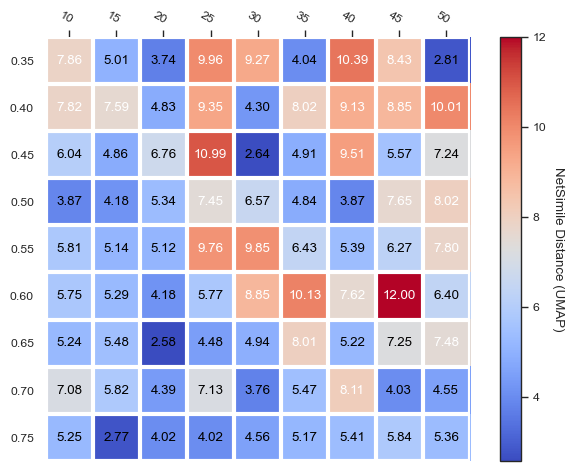

In [6]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_netsimile_umap, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="NetSimile Distance (UMAP)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

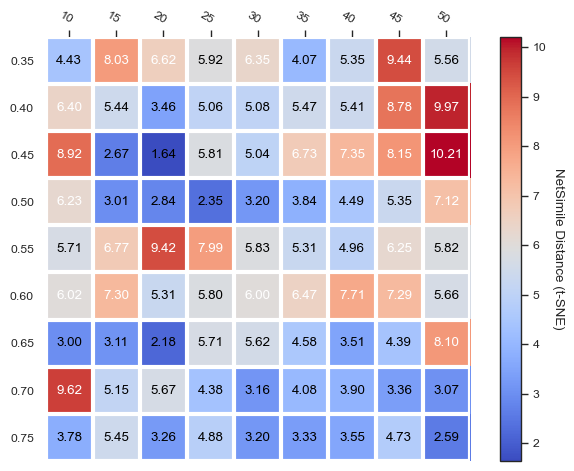

In [7]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_netsimile_tsne, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="NetSimile Distance (t-SNE)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

# **Graphs construction**

In [8]:
mapper_umap = km.KeplerMapper(verbose=1)
mapper_tsnse = km.KeplerMapper(verbose=1)

# UMAP
lens_umap = mapper_umap.fit_transform(x, projection=UMAP(n_components=2, random_state=42), scaler=None)
graph_umap = mapper_umap.map(lens_umap, X=x, 
                             cover=km.Cover(n_cubes=20, perc_overlap=0.65),
                             clusterer=DBSCAN(eps=optimize_dbscan_eps(x, threshold=95), min_samples=2))

# t-SNE
lens_tsne = mapper_tsnse.fit_transform(x, projection=TSNE(n_components=2, random_state=42), scaler=None)
graph_tsne = mapper_tsnse.map(lens_tsne, X=x, 
                              cover=km.Cover(n_cubes=20, perc_overlap=0.45),
                              clusterer=DBSCAN(eps=optimize_dbscan_eps(x, threshold=95), min_samples=2))

# Convert graph to DyNeuGraph
graph_umap_dsr = dsr.DyNeuGraph(G=graph_umap, y=y)
graph_tsne_dsr = dsr.DyNeuGraph(G=graph_tsne, y=y)

KeplerMapper()
KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: UMAP(random_state=42)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (578, 12720)

..Projecting data using: 
	UMAP(random_state=42, verbose=1)

UMAP(random_state=42, verbose=1)
Thu Mar  7 14:20:57 2024 Construct fuzzy simplicial set
Thu Mar  7 14:20:58 2024 Finding Nearest Neighbors
Thu Mar  7 14:20:58 2024 Finished Nearest Neighbor Search
Thu Mar  7 14:20:59 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Mar  7 14:21:00 2024 Finished embedding
Mapping on data shaped (578, 12720) using lens shaped (578, 2)

Creating 400 hypercubes.

Created 2782 edges and 297 nodes in 0:00:00.976111.
..Composing projection pipeline of length 1:
	Projections: TSNE(random_state=42)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (578, 12720)

..Projecting data using: 
	TSNE(random_state=42, verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 578 samples in 0.025s...
[t-SNE] Computed neighbors for 578 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 578 / 578
[t-SNE] Mean sigma: 28.287651
[t-SNE] KL divergence after 250 iterations with e

label,group,value,row_count
CHR,0,104,578
HC,1,248,578
ROD,2,111,578
ROP,3,115,578


   > Found 0 nodes for data point 2.
   > Found 0 nodes for data point 36.
   > Found 0 nodes for data point 59.
   > Found 0 nodes for data point 95.
   > Found 0 nodes for data point 123.
   > Found 0 nodes for data point 180.
   > Found 0 nodes for data point 186.
   > Found 0 nodes for data point 190.
   > Found 0 nodes for data point 223.
   > Found 0 nodes for data point 245.
   > Found 0 nodes for data point 270.
   > Found 0 nodes for data point 304.
   > Found 0 nodes for data point 330.
   > Found 0 nodes for data point 385.
   > Found 0 nodes for data point 396.
   > Found 0 nodes for data point 410.
   > Found 0 nodes for data point 432.
   > Found 0 nodes for data point 450.
   > Found 0 nodes for data point 456.
   > Found 0 nodes for data point 458.
   > Found 0 nodes for data point 459.
   > Found 0 nodes for data point 468.
   > Found 0 nodes for data point 473.
   > Found 0 nodes for data point 482.
   > Found 0 nodes for data point 496.
   > Found 0 nodes for data po

label,group,value,row_count
CHR,0,104,578
HC,1,248,578
ROD,2,111,578
ROP,3,115,578


   > Found 0 nodes for data point 2.
   > Found 0 nodes for data point 8.
   > Found 0 nodes for data point 36.
   > Found 0 nodes for data point 42.
   > Found 0 nodes for data point 59.
   > Found 0 nodes for data point 95.
   > Found 0 nodes for data point 123.
   > Found 0 nodes for data point 124.
   > Found 0 nodes for data point 128.
   > Found 0 nodes for data point 172.
   > Found 0 nodes for data point 174.
   > Found 0 nodes for data point 175.
   > Found 0 nodes for data point 180.
   > Found 0 nodes for data point 186.
   > Found 0 nodes for data point 190.
   > Found 0 nodes for data point 214.
   > Found 0 nodes for data point 223.
   > Found 0 nodes for data point 239.
   > Found 0 nodes for data point 242.
   > Found 0 nodes for data point 245.
   > Found 0 nodes for data point 270.
   > Found 0 nodes for data point 291.
   > Found 0 nodes for data point 304.
   > Found 0 nodes for data point 334.
   > Found 0 nodes for data point 338.
   > Found 0 nodes for data point

In [ ]:
# Visualize graphs
graph_umap_dsr.visualize('graph_tsne_best.html', show=True)
graph_tsne_dsr.visualize('graph_umap_best.html', show=True)

# **Graphs comparison**

In [10]:
graph_umap_1 = mapper_umap.map(lens_umap, X=x,
                               cover=km.Cover(n_cubes=45, perc_overlap=0.60),
                               clusterer=DBSCAN(eps=optimize_dbscan_eps(x, threshold=95), min_samples=2))

graph_tsne_1 = mapper_tsnse.map(lens_tsne, X=x,
                                cover=km.Cover(n_cubes=50, perc_overlap=0.45),
                                clusterer=DBSCAN(eps=optimize_dbscan_eps(x, threshold=95), min_samples=2))

Mapping on data shaped (578, 12720) using lens shaped (578, 2)

Creating 2025 hypercubes.

Created 3902 edges and 805 nodes in 0:00:01.094220.
Mapping on data shaped (578, 12720) using lens shaped (578, 2)

Creating 2500 hypercubes.

Created 785 edges and 453 nodes in 0:00:00.364523.


In [ ]:
# Visualize graphs
graph_umap_dsr_1 = dsr.DyNeuGraph(G=graph_umap_1, y=y)
graph_tsne_dsr_1 = dsr.DyNeuGraph(G=graph_tsne_1, y=y)

graph_umap_dsr_1.visualize('graph_tsne_1.html', show=True)
graph_tsne_dsr_1.visualize('graph_umap_1.html', show=True)